# Simple Microscope Simulation

This notebook demonstrates the individual components of a simple microscope model, then combines them into a complete simulation using the `simple_microscope` function.

## Overview

A simple microscope forward model consists of the following elements:
1. **Sample** - A USAF 1951 resolution test pattern
2. **Linear Interaction** - Light interacts with the sample
3. **Optical Zoom** - Magnification by the objective lens
4. **Circular Aperture** - Limits the numerical aperture
5. **Fraunhofer Propagation** - Far-field propagation to the camera

## Imports

In [1]:
import janssen as jns
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

## Define Simulation Parameters

We create a sample that is:
- 1 mm x 1 mm in physical size
- 0.5 micron pixel spacing
- This gives us 2000 x 2000 pixels

In [3]:
# Physical parameters
sample_size = 1e-3  # 1 mm
pixel_spacing = 0.5e-6  # 0.5 microns
num_pixels = int(sample_size / pixel_spacing)  # 2000 pixels
wavelength = 633e-9  # 633 nm (HeNe laser)

print(f"Sample size: {sample_size * 1e3:.1f} mm")
print(f"Pixel spacing: {pixel_spacing * 1e6:.1f} microns")
print(f"Number of pixels: {num_pixels} x {num_pixels}")
print(f"Wavelength: {wavelength * 1e9:.0f} nm")

Sample size: 1.0 mm
Pixel spacing: 0.5 microns
Number of pixels: 2000 x 2000
Wavelength: 633 nm


## 1. Create USAF 1951 Test Pattern Sample

The USAF 1951 resolution test chart is a standard for measuring optical resolution. It consists of groups of bar patterns at different sizes.

In [4]:
# Calculate DPI to achieve the desired pixel spacing
# DPI = 25.4 mm/inch / (pixel_spacing in mm)
dpi = 25.4e-3 / pixel_spacing
print(f"DPI for {pixel_spacing*1e6} micron pixels: {dpi:.0f}")

# Generate USAF test pattern
# Use groups that give appropriate feature sizes for our pixel spacing
usaf_sample = jns.models.generate_usaf_pattern(
    image_size=num_pixels,
    groups=range(0, 7),  # Groups 0-6
    dpi=dpi,
    dx=pixel_spacing,
)

print(f"Sample shape: {usaf_sample.sample.shape}")
print(f"Sample dx: {usaf_sample.dx * 1e6:.2f} microns")

DPI for 0.5 micron pixels: 50800
Sample shape: (2000, 2000)
Sample dx: 0.50 microns


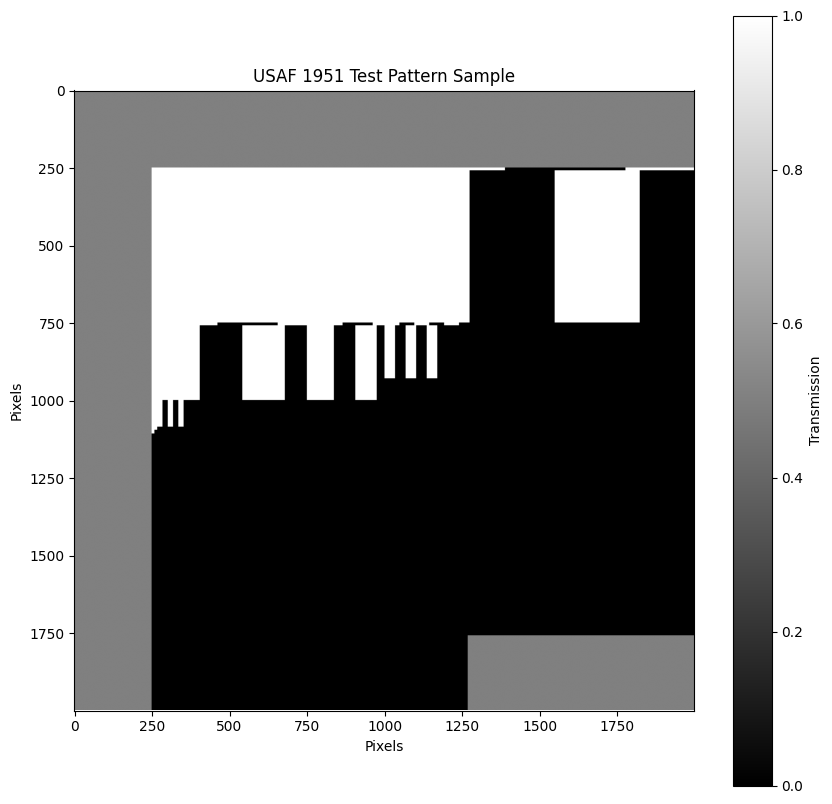

In [5]:
# Visualize the USAF test pattern
plt.figure(figsize=(10, 10))
plt.imshow(jnp.abs(usaf_sample.sample), cmap='gray')
plt.colorbar(label='Transmission')
plt.title('USAF 1951 Test Pattern Sample')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

## 2. Create Illumination Wavefront

We create a collimated (plane wave) illumination to interact with the sample.

In [6]:
# Create a uniform plane wave illumination
# The illumination field should match the size of the region we're imaging
illumination_size = 256  # Size of the illumination field in pixels

# Create uniform illumination
illumination_field = jnp.ones((illumination_size, illumination_size), dtype=jnp.complex128)

# Create optical wavefront
lightwave = jns.utils.make_optical_wavefront(
    field=illumination_field,
    wavelength=wavelength,
    dx=pixel_spacing,
    z_position=0.0,
)

print(f"Illumination field shape: {lightwave.field.shape}")
print(f"Illumination wavelength: {lightwave.wavelength * 1e9:.0f} nm")
print(f"Illumination dx: {lightwave.dx * 1e6:.2f} microns")

Illumination field shape: (256, 256)
Illumination wavelength: 633 nm
Illumination dx: 0.50 microns


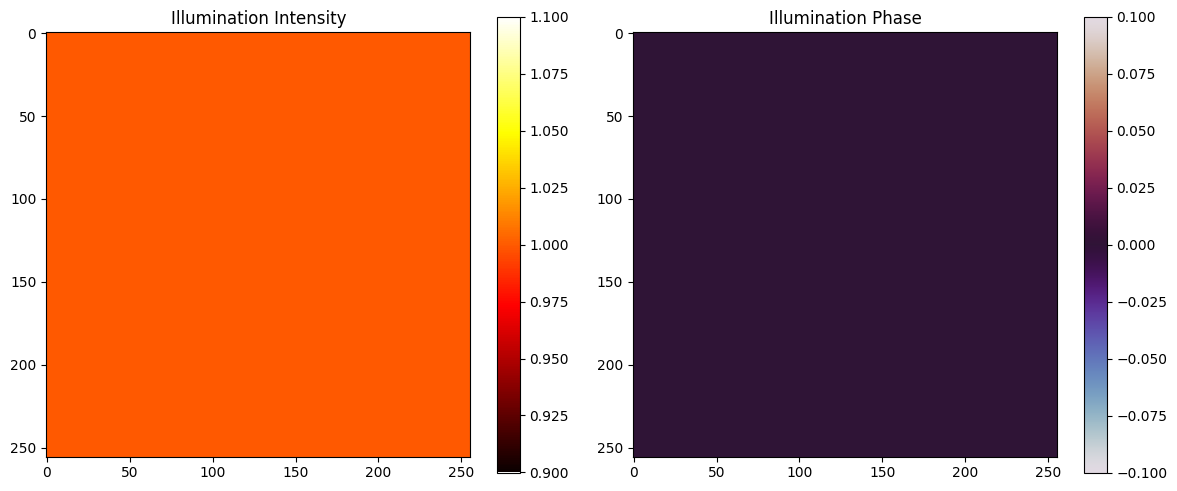

In [7]:
# Visualize the illumination
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(lightwave.field)**2, cmap='hot')
axes[0].set_title('Illumination Intensity')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.angle(lightwave.field), cmap='twilight')
axes[1].set_title('Illumination Phase')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 3. Linear Interaction - Light Through Sample

The `linear_interaction` function models how light passes through a sample. The sample is treated as a complex transmission function that multiplies the incoming wavefront.

In [8]:
# Cut out a region of the sample that matches the illumination size
center = num_pixels // 2
half_size = illumination_size // 2
sample_cut = usaf_sample.sample[center-half_size:center+half_size, 
                                 center-half_size:center+half_size]

# Create a SampleFunction from the cut region
sample_region = jns.utils.make_sample_function(
    sample=sample_cut,
    dx=pixel_spacing,
)

print(f"Sample region shape: {sample_region.sample.shape}")

Sample region shape: (256, 256)


In [9]:
# Apply linear interaction
after_sample = jns.scopes.linear_interaction(
    sample=sample_region,
    light=lightwave,
)

print(f"After sample field shape: {after_sample.field.shape}")
print(f"After sample dx: {after_sample.dx * 1e6:.2f} microns")

After sample field shape: (256, 256)
After sample dx: 0.50 microns


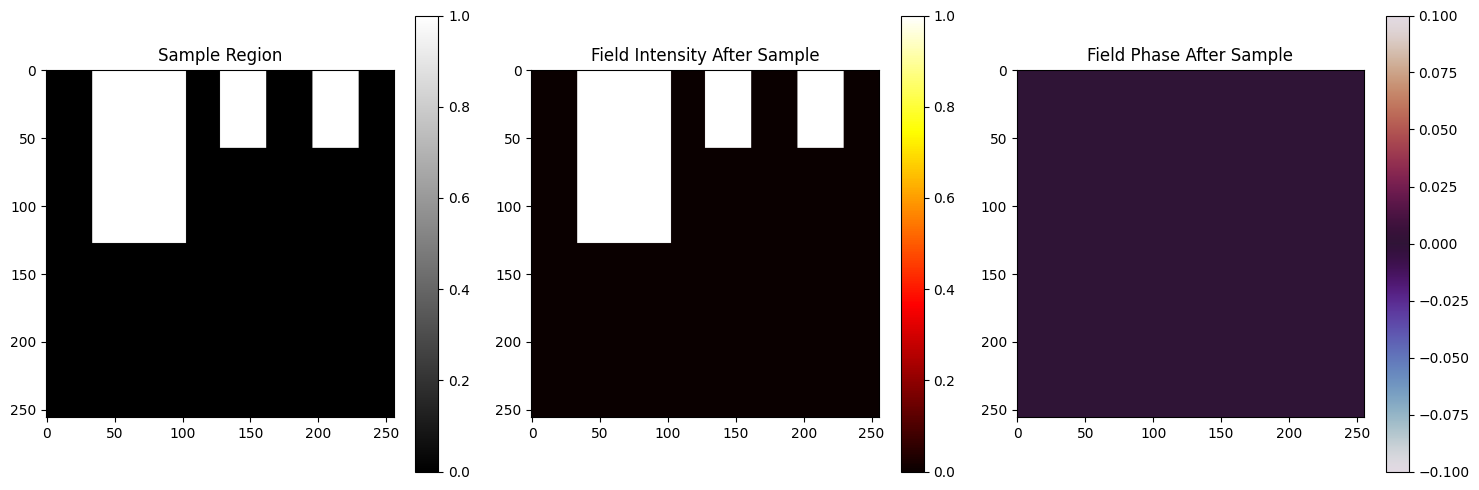

In [10]:
# Visualize the field after interacting with the sample
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(jnp.abs(sample_region.sample), cmap='gray')
axes[0].set_title('Sample Region')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(after_sample.field)**2, cmap='hot')
axes[1].set_title('Field Intensity After Sample')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(jnp.angle(after_sample.field), cmap='twilight')
axes[2].set_title('Field Phase After Sample')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

## 4. Optical Zoom - Magnification

The `optical_zoom` function models the magnification from the objective lens. It scales the pixel size (dx) by the zoom factor while keeping the array size constant.

In [11]:
# Apply optical zoom (magnification)
zoom_factor = 10.0  # 10x magnification

zoomed_wave = jns.prop.optical_zoom(after_sample, zoom_factor)

print(f"Before zoom dx: {after_sample.dx * 1e6:.2f} microns")
print(f"After zoom dx: {zoomed_wave.dx * 1e6:.2f} microns")
print(f"Magnification achieved: {zoomed_wave.dx / after_sample.dx:.1f}x")

Before zoom dx: 0.50 microns
After zoom dx: 5.00 microns
Magnification achieved: 10.0x


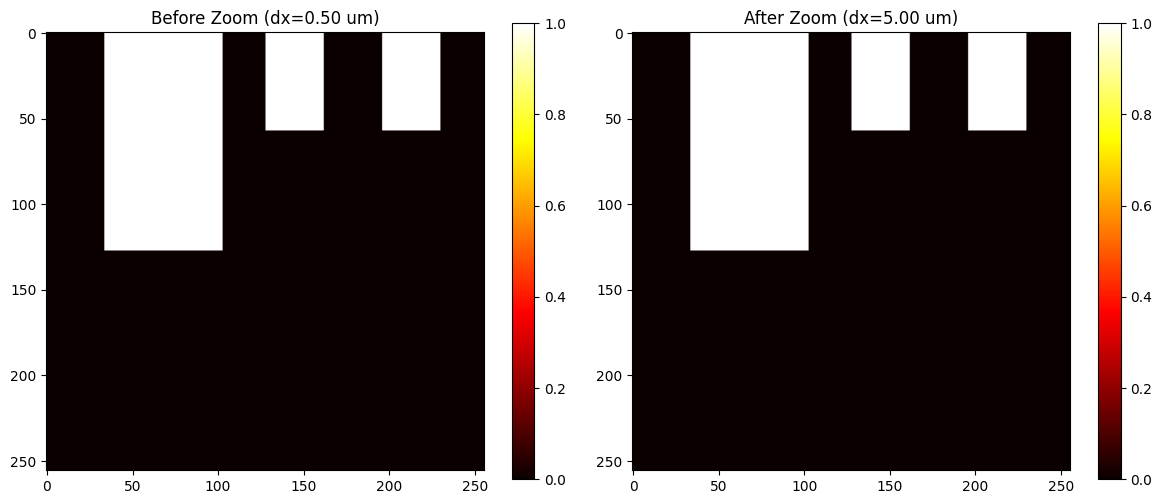

In [12]:
# Visualize the zoomed field
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(after_sample.field)**2, cmap='hot')
axes[0].set_title(f'Before Zoom (dx={after_sample.dx*1e6:.2f} um)')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(zoomed_wave.field)**2, cmap='hot')
axes[1].set_title(f'After Zoom (dx={zoomed_wave.dx*1e6:.2f} um)')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 5. Circular Aperture - Numerical Aperture Limit

The `circular_aperture` function models the limiting aperture of the optical system, which determines the numerical aperture and thus the resolution.

In [13]:
# Apply circular aperture
# The aperture diameter determines the NA of the system
aperture_diameter = 1e-3  # 1 mm aperture

after_aperture = jns.optics.circular_aperture(
    zoomed_wave, 
    diameter=aperture_diameter,
)

print(f"Aperture diameter: {aperture_diameter * 1e3:.1f} mm")

Aperture diameter: 1.0 mm


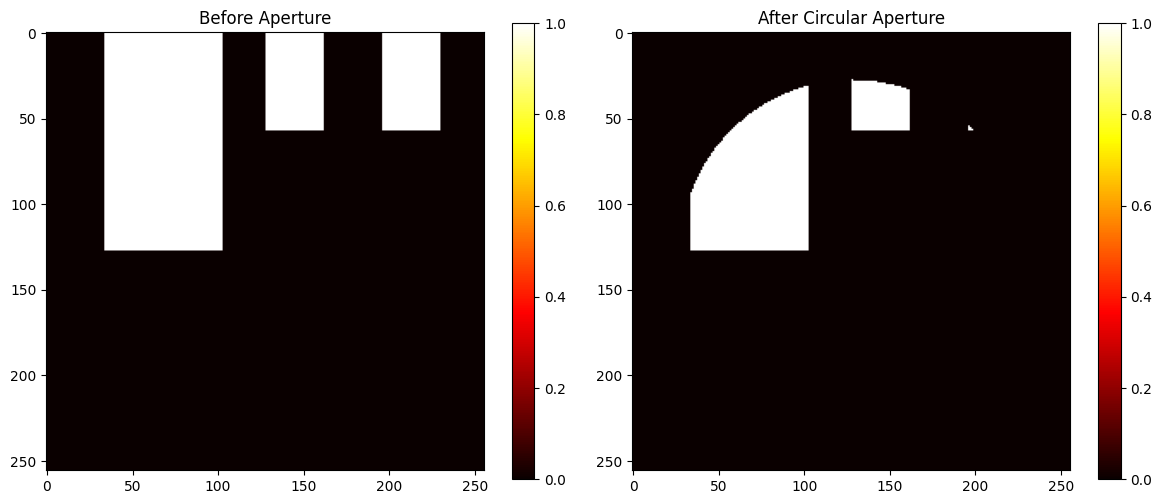

In [14]:
# Visualize the effect of the aperture
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(zoomed_wave.field)**2, cmap='hot')
axes[0].set_title('Before Aperture')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(after_aperture.field)**2, cmap='hot')
axes[1].set_title('After Circular Aperture')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 6. Fraunhofer Propagation - To Camera Plane

The `fraunhofer_prop` function models far-field (Fraunhofer) diffraction, which is appropriate for propagation from the aperture plane to the camera when the propagation distance is large.

In [15]:
# Propagate to camera plane
travel_distance = 0.1  # 100 mm to camera

at_camera = jns.prop.fraunhofer_prop(after_aperture, travel_distance)

print(f"Propagation distance: {travel_distance * 1e3:.0f} mm")
print(f"Camera plane dx: {at_camera.dx * 1e6:.2f} microns")

Propagation distance: 100 mm
Camera plane dx: 49.45 microns


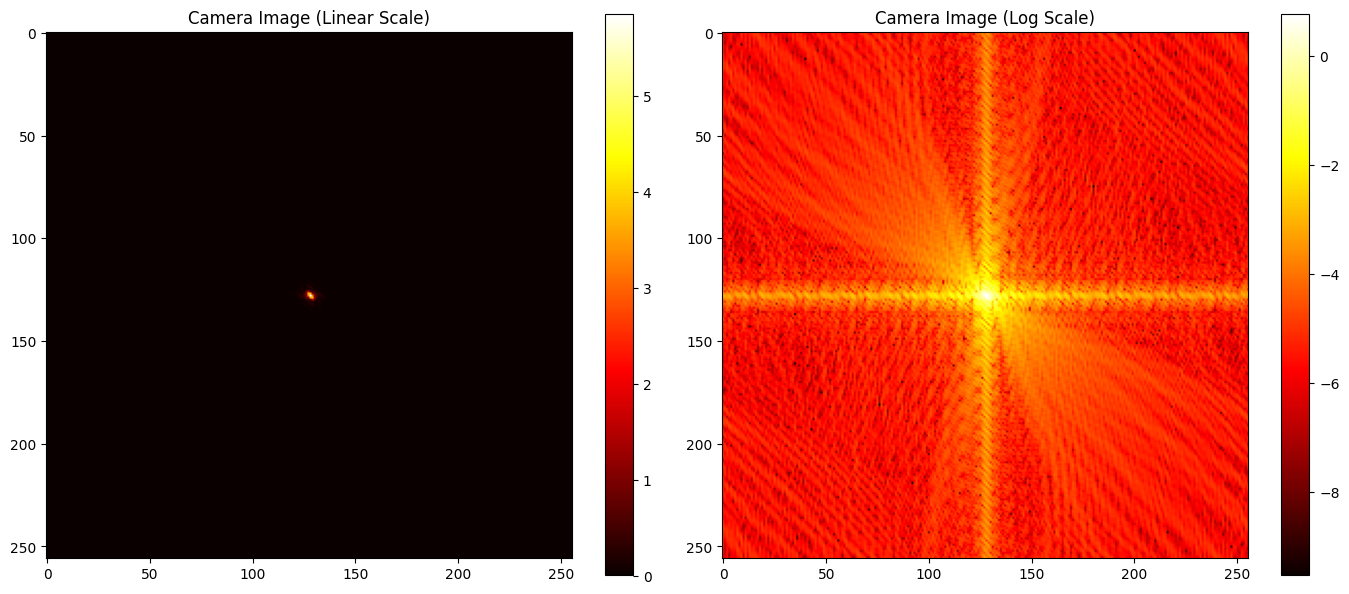

In [16]:
# Calculate the camera image intensity
camera_intensity = jns.optics.field_intensity(at_camera.field)

# Visualize the camera image
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(camera_intensity, cmap='hot')
axes[0].set_title('Camera Image (Linear Scale)')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.log10(camera_intensity + 1e-10), cmap='hot')
axes[1].set_title('Camera Image (Log Scale)')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 7. Complete Pipeline Comparison

Let's compare using the individual steps versus the built-in `simple_diffractogram` function.

In [17]:
# Using simple_diffractogram (combines all steps)
camera_pixel_size = 6.5e-6  # 6.5 micron camera pixels

diffractogram = jns.scopes.simple_diffractogram(
    sample_cut=sample_region,
    lightwave=lightwave,
    zoom_factor=zoom_factor,
    aperture_diameter=aperture_diameter,
    travel_distance=travel_distance,
    camera_pixel_size=camera_pixel_size,
)

print(f"Diffractogram shape: {diffractogram.image.shape}")
print(f"Diffractogram dx: {diffractogram.dx * 1e6:.2f} microns")

TypeCheckError: Type-check error whilst checking the parameters of janssen.optics.apertures.circular_aperture.
The problem arose whilst typechecking parameter 'center'.
Actual value: None
Expected type: typing.Union[float, Float[Array, ''], Float[Array, '2']].
----------------------
Called with parameters: {
  'incoming':
  OpticalWavefront(
    field=c128[256,256](jax),
    wavelength=f64[](jax),
    dx=f64[](jax),
    z_position=f64[](jax),
    polarization=bool[](jax)
  ),
  'diameter': 0.001,
  'center': None,
  'transmittivity': 1.0
}
Parameter annotations: (incoming: janssen.utils.types.OpticalWavefront, diameter: Union[float, Float[Array, '']], center: Union[float, Float[Array, ''], Float[Array, '2']] = 0.0, transmittivity: Union[float, Float[Array, ''], NoneType] = 1.0) -> Any.


In [ ]:
# Visualize the diffractogram
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(diffractogram.image, cmap='hot')
axes[0].set_title('Diffractogram (Linear Scale)')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.log10(diffractogram.image + 1e-10), cmap='hot')
axes[1].set_title('Diffractogram (Log Scale)')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 8. Full Microscope Simulation - Multiple Positions

The `simple_microscope` function can calculate diffractograms at multiple sample positions in parallel using JAX's `vmap`. This is useful for ptychography or scanning microscopy.

In [ ]:
# Define scan positions (in meters)
# Create a 3x3 grid of positions around the center of the sample
scan_step = 50e-6  # 50 micron step size
center_position = sample_size / 2  # Center of the sample

positions_1d = jnp.array([-1, 0, 1]) * scan_step + center_position
pos_x, pos_y = jnp.meshgrid(positions_1d, positions_1d)
positions = jnp.stack([pos_x.ravel(), pos_y.ravel()], axis=1)

print(f"Number of scan positions: {len(positions)}")
print(f"Scan positions (microns):")
print(positions * 1e6)

In [ ]:
# Run the full microscope simulation
microscope_data = jns.scopes.simple_microscope(
    sample=usaf_sample,
    positions=positions,
    lightwave=lightwave,
    zoom_factor=zoom_factor,
    aperture_diameter=aperture_diameter,
    travel_distance=travel_distance,
    camera_pixel_size=camera_pixel_size,
)

print(f"Microscope data image shape: {microscope_data.image_data.shape}")
print(f"Number of diffractograms: {microscope_data.image_data.shape[0]}")

In [ ]:
# Visualize all diffractograms from the scan
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(jnp.log10(microscope_data.image_data[i] + 1e-10), cmap='hot')
    pos = positions[i]
    ax.set_title(f'Pos {i+1}: ({pos[0]*1e6:.0f}, {pos[1]*1e6:.0f}) um')
    ax.axis('off')

plt.suptitle('Diffractograms at Different Scan Positions (Log Scale)', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Effect of Different Parameters

Let's explore how different optical parameters affect the resulting images.

In [ ]:
# Compare different zoom factors (magnifications)
zoom_factors = [5.0, 10.0, 20.0, 40.0]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, zf in enumerate(zoom_factors):
    diff = jns.scopes.simple_diffractogram(
        sample_cut=sample_region,
        lightwave=lightwave,
        zoom_factor=zf,
        aperture_diameter=aperture_diameter,
        travel_distance=travel_distance,
        camera_pixel_size=camera_pixel_size,
    )
    
    # Linear scale
    axes[0, i].imshow(diff.image, cmap='hot')
    axes[0, i].set_title(f'{zf:.0f}x Magnification\n(Linear)')
    axes[0, i].axis('off')
    
    # Log scale
    axes[1, i].imshow(jnp.log10(diff.image + 1e-10), cmap='hot')
    axes[1, i].set_title(f'{zf:.0f}x Magnification\n(Log)')
    axes[1, i].axis('off')

plt.suptitle('Effect of Magnification on Diffractogram', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Compare different aperture sizes (NA)
aperture_diameters = [0.5e-3, 1e-3, 2e-3, 5e-3]  # mm

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, ap in enumerate(aperture_diameters):
    diff = jns.scopes.simple_diffractogram(
        sample_cut=sample_region,
        lightwave=lightwave,
        zoom_factor=zoom_factor,
        aperture_diameter=ap,
        travel_distance=travel_distance,
        camera_pixel_size=camera_pixel_size,
    )
    
    # Linear scale
    axes[0, i].imshow(diff.image, cmap='hot')
    axes[0, i].set_title(f'Aperture: {ap*1e3:.1f} mm\n(Linear)')
    axes[0, i].axis('off')
    
    # Log scale
    axes[1, i].imshow(jnp.log10(diff.image + 1e-10), cmap='hot')
    axes[1, i].set_title(f'Aperture: {ap*1e3:.1f} mm\n(Log)')
    axes[1, i].axis('off')

plt.suptitle('Effect of Aperture Size on Diffractogram', fontsize=14)
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **USAF 1951 Test Pattern**: Created a standard resolution test pattern using `generate_usaf_pattern`

2. **Linear Interaction**: Light-sample interaction via `linear_interaction` - multiplies the wavefront by the sample transmission function

3. **Optical Zoom**: Magnification using `optical_zoom` - scales the pixel size by the zoom factor

4. **Circular Aperture**: NA limitation via `circular_aperture` - applies a circular mask to limit spatial frequencies

5. **Fraunhofer Propagation**: Far-field diffraction using `fraunhofer_prop` - propagates to the camera plane

6. **Complete Microscope**: The `simple_microscope` function combines all these elements and can process multiple positions in parallel

The janssen library provides differentiable implementations of all these operations, making it suitable for gradient-based optimization in ptychography and other inverse problems.